#0.Imports and Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#imports

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
import time
import re
import json
import string
from numpy import linalg as la

In [ ]:
#We create the path to our tweets file and store in the line variable the information of each tweet from the json file and we also create the path to the ids csv

tweets_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Rus_Ukr_war_data.json"
with open(tweets_path) as fp:
    lines = fp.readlines()

id_to_docs_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Rus_Ukr_war_data_ids.csv"

#1.Pre-process the data

##Covertion of the data into a dataframe

In [ ]:
#first of all we will convert our data into a dataframe, we will only take the variables we are interested in (columns of the df)

import pandas as pd
df = pd.DataFrame(columns = ['Id','Tweet','Date','Hashtags','Likes','Retweets','Url'])

#for each line we will read the variable we want and store it on the df
for l in lines:
  parsed_line = json.loads(l)
  id = parsed_line["id"]
  text = parsed_line["full_text"]
  date = parsed_line["created_at"]
  hashtags = parsed_line["entities"]["hashtags"][0]["text"]
  likes = parsed_line["favorite_count"]
  retweets = parsed_line["retweet_count"]
  try:
    url = parsed_line['entities']['media'][0]['url']
  except (KeyError, IndexError):
    url = None

  row = {'Id':id,'Tweet':text,'Date':date,'Hashtags':hashtags,'Likes':likes,'Retweets':retweets,'Url':url}
  new_row = pd.DataFrame([row])
  df = pd.concat([df, new_row], ignore_index=True)

#we also store the data from the csv file into a df
df_docs = pd.read_csv(id_to_docs_path, delimiter='\t', names=['Doc','Id'])

In [ ]:
display (df)

,Id,Tweet,Date,Hashtags,Likes,Retweets,Url
0,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,Fri Sep 30 18:39:17 +0000 2022,RussiainvadesUkraine,0,0,None
1,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,Fri Sep 30 18:38:44 +0000 2022,Drobysheve,0,0,https://t.co/ifg0RXDMBQ
2,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,Fri Sep 30 18:38:23 +0000 2022,NATO,0,0,None
3,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,Fri Sep 30 18:38:03 +0000 2022,Putin,0,0,None
4,1575917878410301441,@EmmanuelMacron probably you're right or you h...,Fri Sep 30 18:37:56 +0000 2022,European,0,0,None
...,...,...,...,...,...,...,...
3995,1575154617620504576,🎥 Ukraine’s president has warned that Russia’s...,Wed Sep 28 16:05:00 +0000 2022,UkraineRussiaWar,4,1,https://t.co/Ld9SN2pz25
3996,1575154444165156864,Germany amusingly shares days old intelligense...,Wed Sep 28 16:04:19 +0000 2022,germany,0,0,None
3997,1575154440012812288,The US Embassy in Moscow is urging Americans t...,Wed Sep 28 16:04:18 +0000 2022,fakenewsfilter,0,0,https://t.co/uI4jNf1n18
3998,1575154351273873410,After the staged fake referendum as of Septemb...,Wed Sep 28 16:03:56 +0000 2022,UkraineRussiaWar,13,2,https://t.co/XQOJq8b3M1


In [ ]:
display (df_docs)

,Doc,Id
0,doc_1,1575918221013979136
1,doc_2,1575918081461080065
2,doc_3,1575917992390823936
3,doc_4,1575917907774967809
4,doc_5,1575917878410301441
...,...,...
3995,doc_3996,1575154617620504576
3996,doc_3997,1575154444165156864
3997,doc_3998,1575154440012812288
3998,doc_3999,1575154351273873410


In [ ]:
#to end this process we will join both dataframes so each tweet, in addition to the information we selected, will have its doc id

result_df = pd.merge(df, df_docs, on='Id', how='inner')
result_df = result_df[['Doc','Id','Tweet','Date','Hashtags','Likes','Retweets','Url']]
display(result_df)

,Doc,Id,Tweet,Date,Hashtags,Likes,Retweets,Url
0,doc_1,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,Fri Sep 30 18:39:17 +0000 2022,RussiainvadesUkraine,0,0,None
1,doc_2,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,Fri Sep 30 18:38:44 +0000 2022,Drobysheve,0,0,https://t.co/ifg0RXDMBQ
2,doc_3,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,Fri Sep 30 18:38:23 +0000 2022,NATO,0,0,None
3,doc_4,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,Fri Sep 30 18:38:03 +0000 2022,Putin,0,0,None
4,doc_5,1575917878410301441,@EmmanuelMacron probably you're right or you h...,Fri Sep 30 18:37:56 +0000 2022,European,0,0,None
...,...,...,...,...,...,...,...,...
3995,doc_3996,1575154617620504576,🎥 Ukraine’s president has warned that Russia’s...,Wed Sep 28 16:05:00 +0000 2022,UkraineRussiaWar,4,1,https://t.co/Ld9SN2pz25
3996,doc_3997,1575154444165156864,Germany amusingly shares days old intelligense...,Wed Sep 28 16:04:19 +0000 2022,germany,0,0,None
3997,doc_3998,1575154440012812288,The US Embassy in Moscow is urging Americans t...,Wed Sep 28 16:04:18 +0000 2022,fakenewsfilter,0,0,https://t.co/uI4jNf1n18
3998,doc_3999,1575154351273873410,After the staged fake referendum as of Septemb...,Wed Sep 28 16:03:56 +0000 2022,UkraineRussiaWar,13,2,https://t.co/XQOJq8b3M1


##Pre-processing the tweets

In [ ]:
#now we will use the structure of build terms seen on the first lab to pre-process the text of each tweet
#we will add a few lines to eliminate from the tweets the urls, the @s, the numbers, the #s and the emojis
def build_terms(line):
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words("english"))
  punctuations = string.punctuation

  line =  line.lower() ## Transform in lowercase
  line = re.sub(r'http.*', '',line)
  line = re.sub(r'@\w+', '', line)
  line = re.sub(r'\d+','', line)
  line = re.sub(r'#\w+|[^\x00-\x7F]+|['+ re.escape(punctuations) + ']', ' ',line)
  line=  line.split() ## Tokenize the text to get a list of terms
  line=[x for x in line if x not in stop_words]  ##eliminate the stopwords
  line=[stemmer.stem(word) for word in line] ## perform stemming

  return line

In [ ]:
#we will create a dataframe where we will have for each tweet its terms and its number of terms
df_terms = pd.DataFrame(columns=['Tweet', 'Terms', 'Number_Terms'])
dictionary = {}
for element in result_df['Tweet']:
  term_list = build_terms(element)

  row = {'Tweet':element,'Terms':term_list, 'Number_Terms': len(term_list)}
  new_row = pd.DataFrame([row])
  df_terms = pd.concat([df_terms, new_row], ignore_index=True)

  for term in term_list:
    if term not in dictionary:
      dictionary[term] = 1
    else:
      dictionary[term] += 1

#2.Exploratory Data Analysis

##Word Counting Distribution


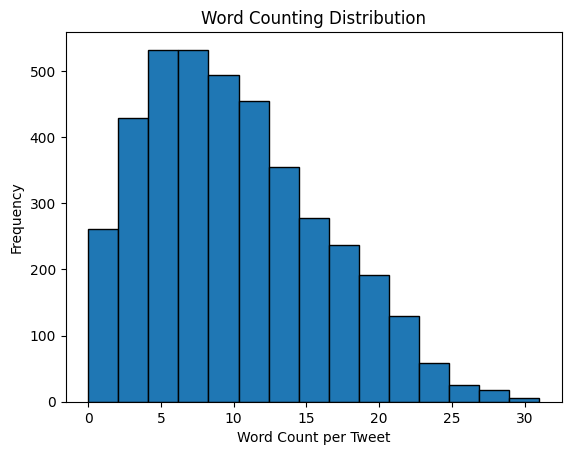

In [ ]:
#To start with the data analysis we will plot a distribution of the frequency of tweets with certain numbers of terms
import matplotlib.pyplot as plt

plt.hist(df_terms['Number_Terms'], bins=15, edgecolor='k')
plt.xlabel('Word Count per Tweet')
plt.ylabel('Frequency')
plt.title('Word Counting Distribution')

plt.show()

##Average Tweet Length

In [ ]:
#now we will count the average of terms per tweet
number_tweets = 0
count = 0
for terms in df_terms['Terms']:
  count += len(terms)
  number_tweets += 1

average = count/number_tweets
print(f'The average number of words per each tweet is {average} words.')

The average number of words per each tweet is 10.289 words.


##Vocabulary Size

In [ ]:
#the vocabulary size will be the length of our terms dictionary
len(dictionary)

5509

##Top 10 Most Retweeted Tweets


In [ ]:
#now we will display the top 10 most retweeted tweets
df_rt = result_df.sort_values(by='Retweets', ascending=False)
display(df_rt[['Tweet','Retweets']].head(10))

,Tweet,Retweets
1219,🗺️Situation around Lyman - Sep 30 11:00:\n- UA...,646
2813,📷Unique and rare photos of Ukrainian forward c...,338
3765,📽️Operation Interflex: Ukrainian recruits cont...,283
1846,The following countries have urged their citiz...,251
1387,📽️Russians shelled the outskirts of #Zaporizhz...,247
1209,The war will not end with the so called annexa...,236
1532,Russia may have dropped 11 meters long X-22 mi...,184
205,📽️🇺🇦 Ukrainian forces liberated Drobysheve in ...,171
2118,"🗞️Kostyantyn Nemichev, the commander of Kraken...",136
3801,📽️Ukrainian paratroopers on BTR-3 during the o...,133


##Word Cloud

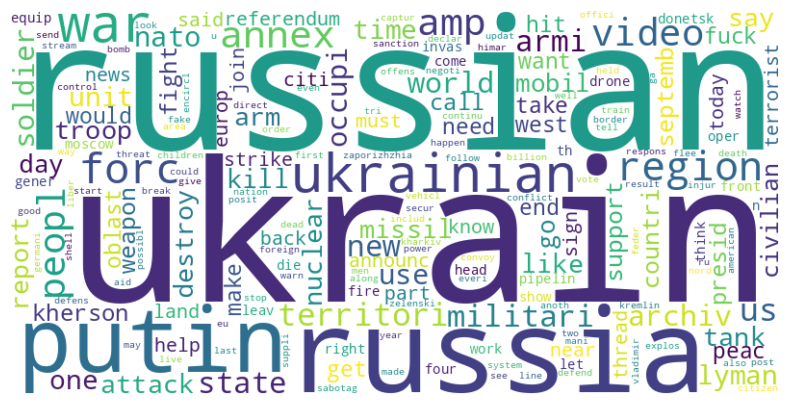

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#we create a wordcloud with the frequencies of the terms that appear on our dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud from the word count dictionary
wordcloud.generate_from_frequencies(dictionary)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


##Entity Recognition

In [ ]:
import spacy
from spacy import displacy
NER = spacy.load("en_core_web_sm")

entity_dict = {
    "Labels" : {},
    "EntitiesName" : {}
}

for terms in df_terms['Terms']:
  text1 = NER(' '.join(terms))
  for word in text1.ents:
    if word.label_ not in entity_dict["Labels"]:
      entity_dict["Labels"][word.label_] = 1
    else:
      entity_dict["Labels"][word.label_] += 1

    if word.text not in entity_dict["EntitiesName"]:
      entity_dict["EntitiesName"][word.text] = [1, word.label_]
    else:
      entity_dict["EntitiesName"][word.text][0] += 1

In [ ]:
display(entity_dict)

{'Labels': {'PERSON': 1668,
  'GPE': 1078,
  'FAC': 12,
  'ORG': 1021,
  'NORP': 1215,
  'CARDINAL': 286,
  'LANGUAGE': 15,
  'EVENT': 15,
  'DATE': 298,
  'ORDINAL': 56,
  'TIME': 53,
  'WORK_OF_ART': 3,
  'LOC': 27,
  'PRODUCT': 18,
  'QUANTITY': 3,
  'MONEY': 5,
  'LAW': 2},
 'EntitiesName': {'putin': [135, 'PERSON'],
  'russia': [591, 'GPE'],
  'poland': [16, 'GPE'],
  'estonia': [5, 'GPE'],
  'lithuania': [4, 'GPE'],
  'latvia fulli': [1, 'FAC'],
  'nato': [90, 'ORG'],
  'unsanitari chemic biolab': [1, 'PERSON'],
  'russian': [964, 'NORP'],
  'putin cheer': [1, 'PERSON'],
  'moscow': [59, 'GPE'],
  'berlin': [4, 'GPE'],
  'brussel': [1, 'GPE'],
  'london': [4, 'GPE'],
  'stockholm': [1, 'GPE'],
  'thousand': [11, 'CARDINAL'],
  'kilomet percent': [1, 'ORG'],
  'putin mobilis': [2, 'PERSON'],
  'nyc putin': [1, 'GPE'],
  'four': [55, 'CARDINAL'],
  'armi': [118, 'ORG'],
  'ifv': [1, 'CARDINAL'],
  'world war ii': [2, 'EVENT'],
  'hey putin': [1, 'PERSON'],
  'negoti long': [1, 'PER

In [ ]:
from collections import Counter

labels_counter = Counter()
for label, count in entity_dict['Labels'].items():
    labels_counter[label] += count

entities_counter = Counter()
for name, (count, label) in entity_dict['EntitiesName'].items():
    entities_counter[name] += count

most_common_labels = labels_counter.most_common(5)

most_common_entities = entities_counter.most_common(5)

print("Most Common Labels:")
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")

print("\nMost Common Entity Names:")
for name, count in most_common_entities:
    print(f"Entity Name: {name}, Count: {count}")


Most Common Labels:
Label: PERSON, Count: 1668
Label: NORP, Count: 1215
Label: GPE, Count: 1078
Label: ORG, Count: 1021
Label: DATE, Count: 298

Most Common Entity Names:
Entity Name: russian, Count: 964
Entity Name: russia, Count: 591
Entity Name: putin, Count: 135
Entity Name: armi, Count: 118
Entity Name: one, Count: 95
